This notebook includes some different ways of collecting and analyzing data from a basic El Farol Bar Problem Simulation.

# Summarizing a single run

The current default parameters for the simulation are:
```
# number of agents
agents = 100, 

# threshold for attendance
threshold = 60,

# number of strategies
strategies = 10, 

# number of weeks back in predictor function
# AND number of weeks back to look when selecting a predictor
memory = 8,

# number of rounds to run the simulation
n_iter = 200,

# random seed for numpy
seed=23
```

In [1]:
import numpy as np
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from efbp import run_simulation


def detect_cycle(hist, memory):
    """
    return the cycle length if there is a cycle longer 2*memory
    
    Repeated patterns of length less than 2*memory may not repeat
    indefinitely as attendance at each timestep relies on the previous
    2 * memory timesteps.
    """
    l = 2 * memory # minimum cycle length

    tail = hist[-l :]

    # we must leave space for an entire pattern repeat
    # of length *l* before the beginning of the tail
    for i in range(len(hist) - 2*l -1, 0, -1):
        if (hist[i:i+l] == tail).all():
            return len(hist) - l - i
    return None


def summarize_run(**kwargs):
    
    hist, best_strat, pred_history = run_simulation(**kwargs)

    plt.figure()
    plt.title("Weekly Attendance")
    plt.xlabel("Time")
    plt.ylabel("Number attending")
    plt.plot(hist)
    plt.plot([-1, len(hist)+1], [60, 60], "--")

    
    plt.figure()
    # disregard the first 100 weeks to give the system
    # time to settle
    plt.hist((pred_history[:, 100:] < 60).sum(axis=1) / (len(hist) - 50), bins=20)
    plt.title("Attendance Rates")
    plt.xlabel("Rate")
    plt.ylabel("Agent Count")
    
    plt.figure()
    plt.title("Strategies Used per Agent")
    plt.xlabel("Number of strategies")
    plt.ylabel("Agent Count")
    
    # once again, disregard the first 100 weeks
    steady_state_strats = np.apply_along_axis(
        lambda a: len(np.unique(a)),
        1,
        best_strat[:, 100:],
    )

    plt.hist(steady_state_strats, bins=steady_state_strats.max())
    
    memory = kwargs.get("memory", 8)
    cl = detect_cycle(hist, memory)
    print("Cycle length: {}".format(cl))
    
    if cl:
        print(hist[-cl:])

Cycle length: None


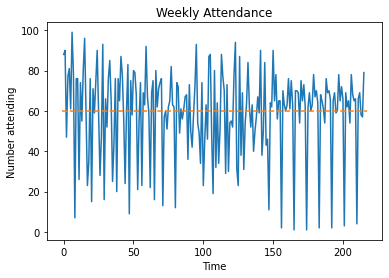

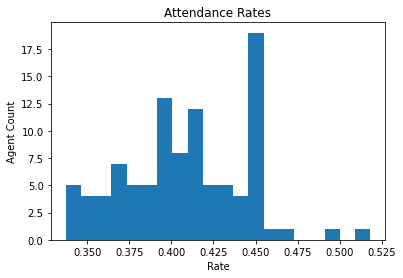

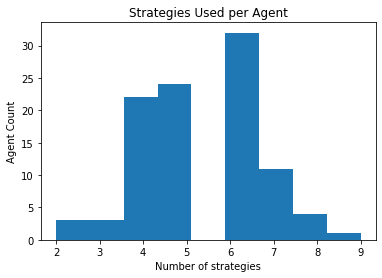

In [2]:
summarize_run(seed=444445, n_iter=200)

Whoa!  Ten strategies already looks like way too much.  Let's try some smaller numbers.

Cycle length: None


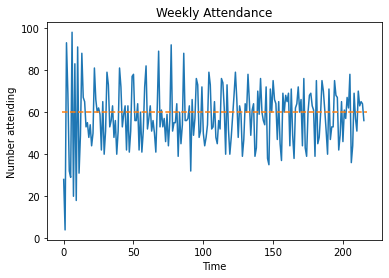

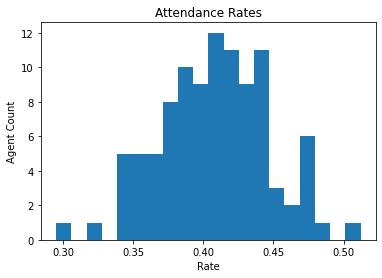

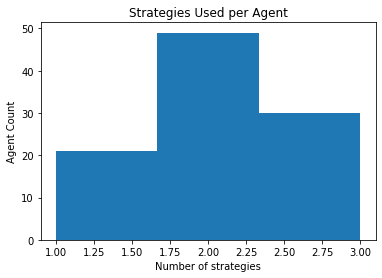

In [3]:
summarize_run(seed=444445, n_iter=200, strategies=3)

Cycle length: None


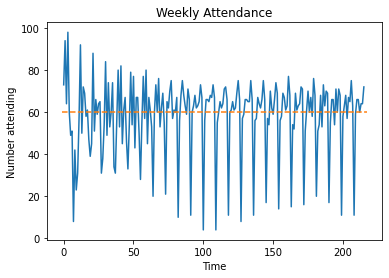

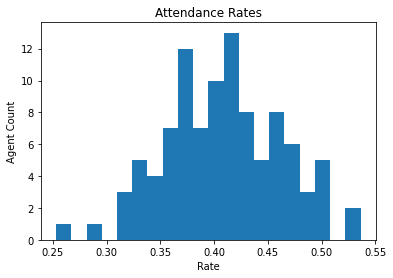

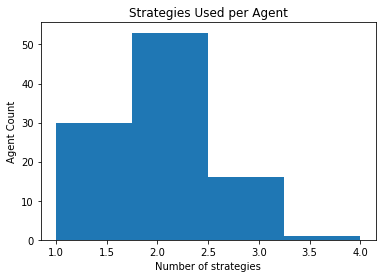

In [4]:
summarize_run(seed=444445, n_iter=200, strategies=4)

Cycle length: None


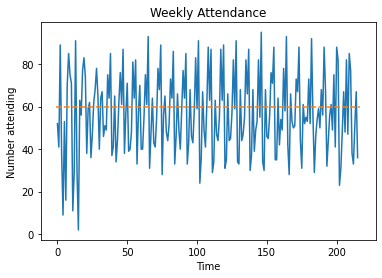

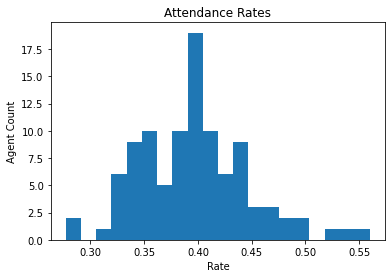

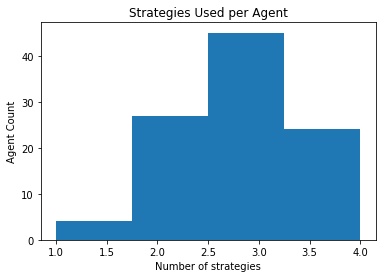

In [5]:
summarize_run(seed=444445, strategies=5, n_iter=200)

Cycle length: None


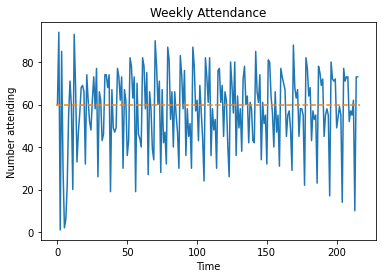

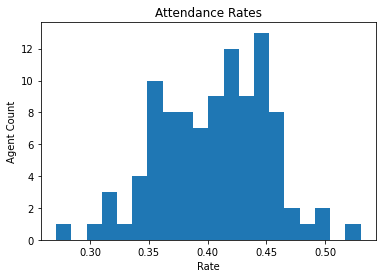

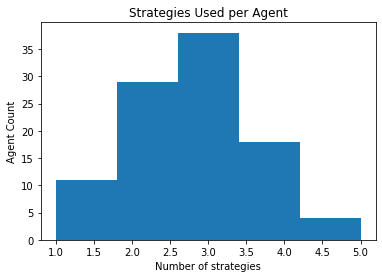

In [6]:
summarize_run(seed=2222, strategies=5, n_iter=200)

Cycle length: None


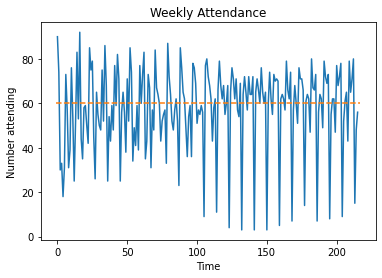

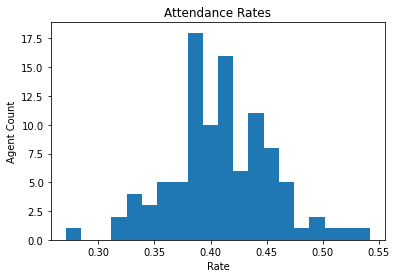

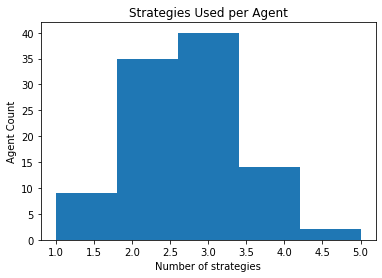

In [7]:
summarize_run(seed=444445, strategies=6, n_iter=200)

Cycle length: None


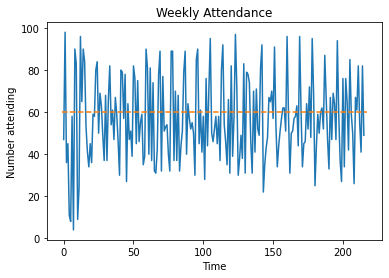

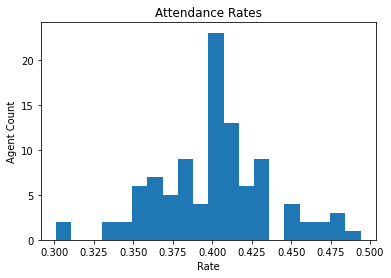

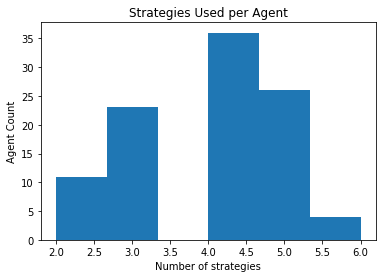

In [8]:
summarize_run(seed=444445, strategies=7, n_iter=200)

Cycle length: None


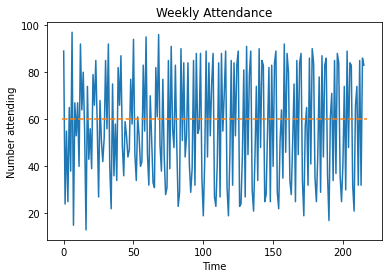

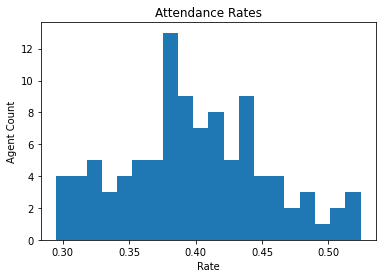

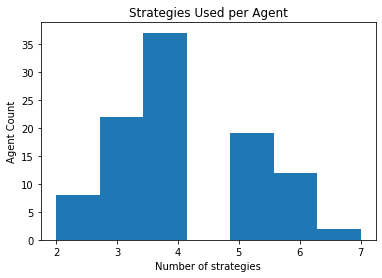

In [9]:
summarize_run(seed=444445, strategies=8, n_iter=200)

Cycle length: None


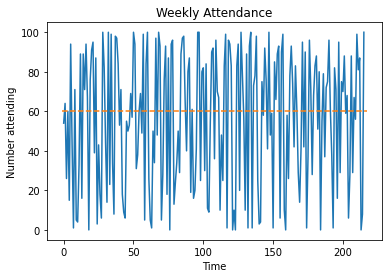

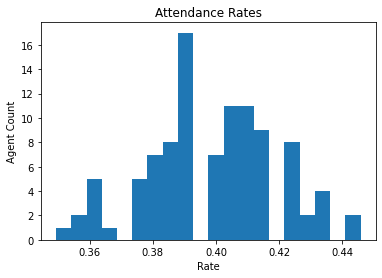

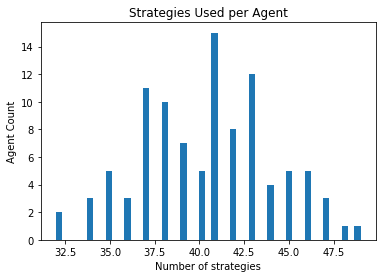

In [10]:
summarize_run(seed=444445, strategies=100, n_iter=200)

Cycle length: None


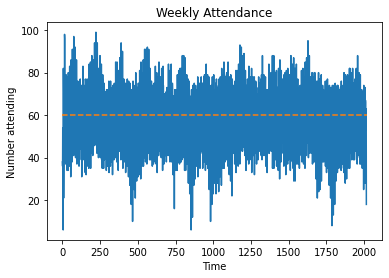

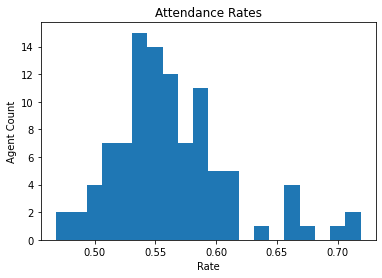

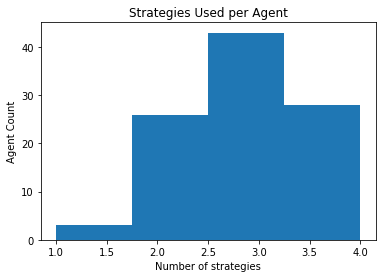

In [12]:
summarize_run(seed=444446, strategies=4, n_iter=2000)

Cycle length: None


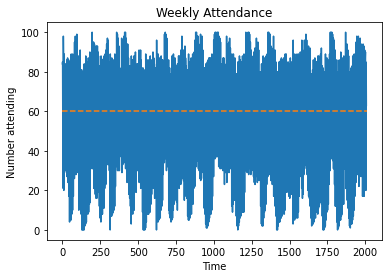

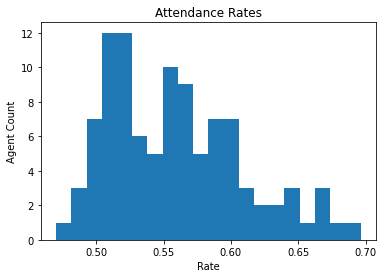

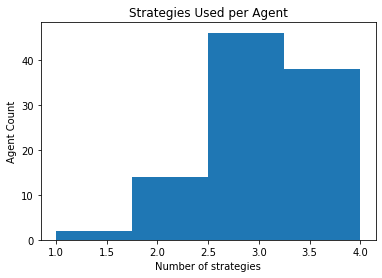

In [13]:
summarize_run(seed=444446, strategies=4, memory=4, n_iter=2000)

It seems like now that we have made the distribution of strategies more reasonable, we see these very large oscillations beginning at lower strategy counts.

# Testing the impact of a parameter over many trials

We can also examine how results vary as we vary a parameter.  In this code, *x_name* identifies the parameter to vary and *x_range* controls the range of values to use.

In [14]:
def utilization(x, threshold=60):
    return (x[np.where(x <= threshold)].sum() - x[np.where(x > threshold)].sum()) / len(x)


def happiness(hist, pred_history, threshold):
    went = (pred_history < threshold)
    happy = hist < threshold

    return (went & happy).sum(axis=1) - (went & ~happy).sum(axis=1)


def attendance_rate(hist, pred_history, threshold):
    return (pred_history < threshold).sum(axis=1) / pred_history.shape[1]


def experiment(x_name, x_range, n_reps, rng, kwargs=dict()):
    X = list(x_range) * n_reps
    utilization_scores = []
    mean_attendance = []
    std_attendance = []
    std_happiness = []
    mean_strats = []
    std_strats = []

    for x in X:
        kwargs[x_name] = x
        kwargs["seed"] = rng.choice(int(1e7))
        
        hist, best_strat, pred_history = run_simulation(**kwargs)
        # truncate beginning to give system time to reach "steady state"
        # TODO: handle steady state better
        hist_ss = hist[100:]
        pred_ss = pred_history[:, 100:]

        utilization_scores.append(utilization(hist_ss))
        mean_attendance.append(hist_ss.mean())
        std_attendance.append(hist_ss.std())
        std_happiness.append(happiness(hist_ss, pred_ss, 60).std())
        
        # once again, disregard the first 100 weeks
        strats_ss = np.apply_along_axis(
            lambda a: len(np.unique(a)),
            1,
            best_strat[:, 100:],
        )
        
        mean_strats.append(strats_ss.mean())
        std_strats.append(strats_ss.std())
    
    df = pd.DataFrame([X, utilization_scores, std_happiness, mean_attendance, std_attendance, mean_strats, std_strats]).T
    df.columns = [x_name, "happiness", "std_happiness", "mean_attendance", "std_attendance", "mean_strats", "std_strats"]

    means = df.groupby(x_name).mean()
    stds = df.groupby(x_name).std()

    for col in df.columns[1:]:
        plt.figure()
        plt.errorbar(means.index, means[col], yerr=stds[col])
        plt.xlabel("Number of {}".format(x_name))
        plt.ylabel("{}".format(col))
        plt.title("{} vs. {}".format(col, x_name))

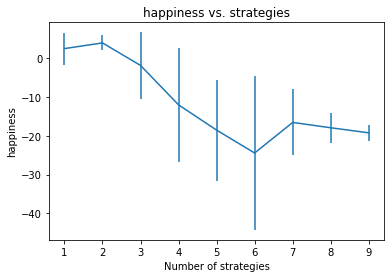

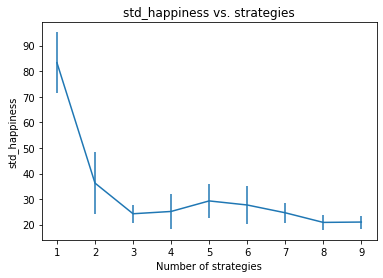

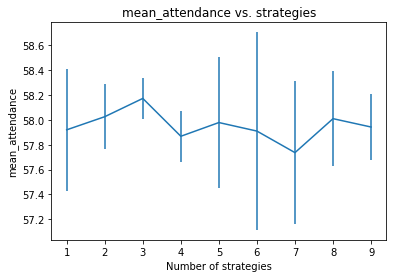

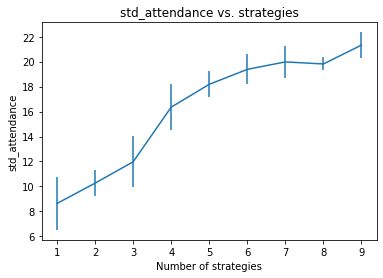

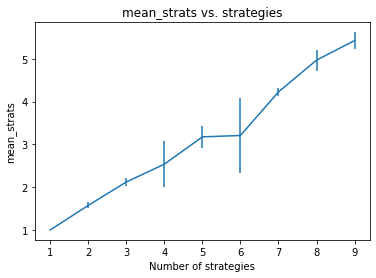

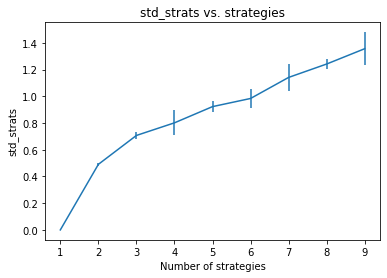

In [15]:
n_reps = 5
x_name = "strategies"
x_range = range(1,10)
rng = np.random.default_rng(81)

experiment(x_name, x_range, n_reps, rng)

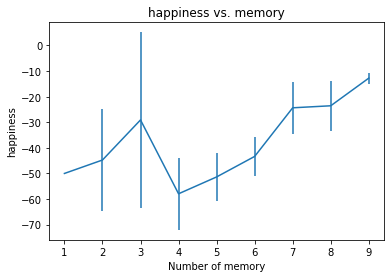

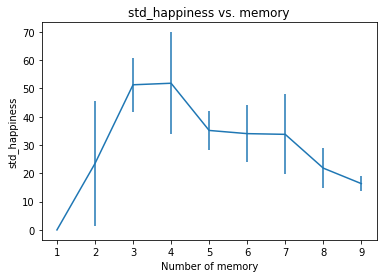

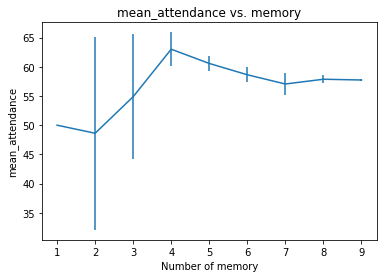

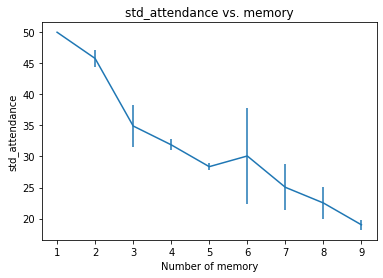

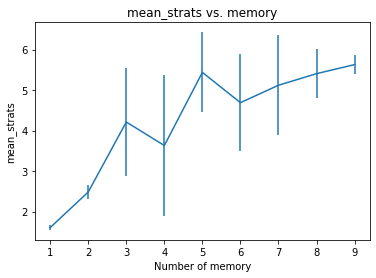

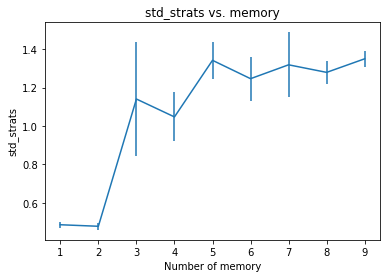

In [16]:
n_reps = 5
x_name = "memory"
x_range = range(1,10)
rng = np.random.default_rng(81)

experiment(x_name, x_range, n_reps, rng)

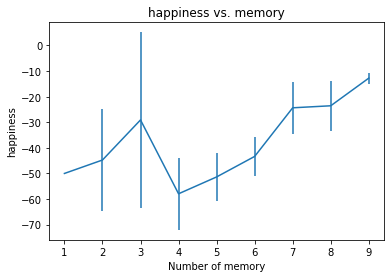

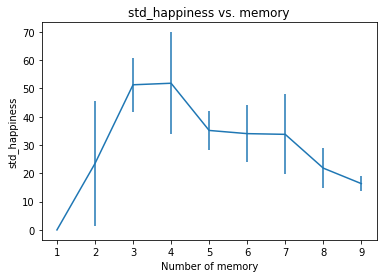

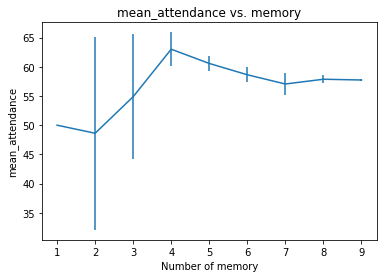

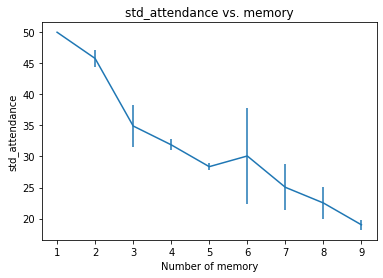

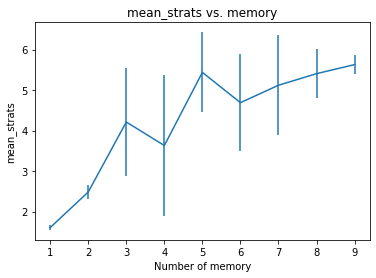

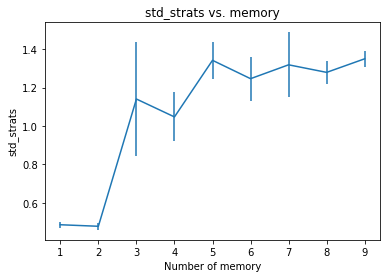

In [17]:
n_reps = 5
x_name = "memory"
x_range = range(1,10)
rng = np.random.default_rng(81)

kwargs = {"strategies": 4}

experiment(x_name, x_range, n_reps, rng)

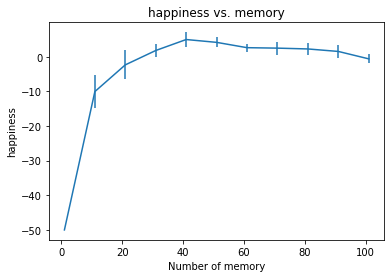

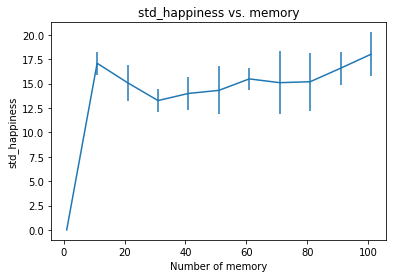

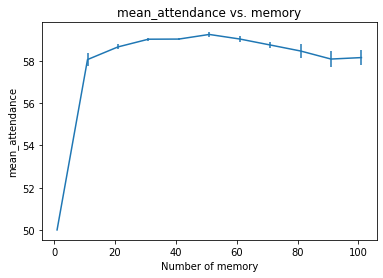

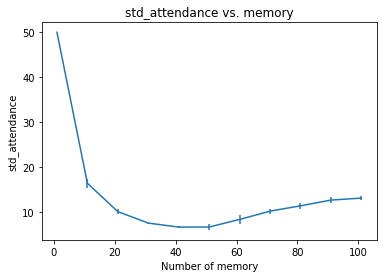

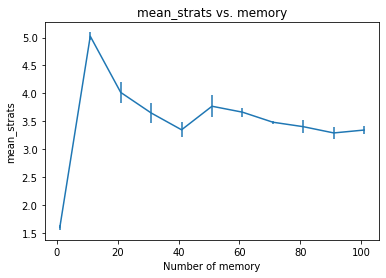

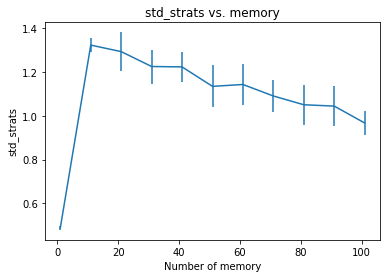

In [18]:
n_reps = 5
x_name = "memory"
x_range = range(1,102, 10)
rng = np.random.default_rng(81)

experiment(x_name, x_range, n_reps, rng)

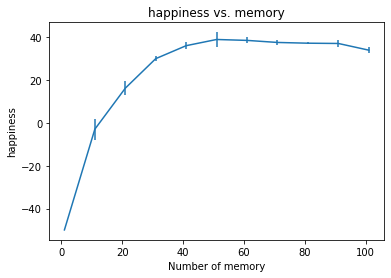

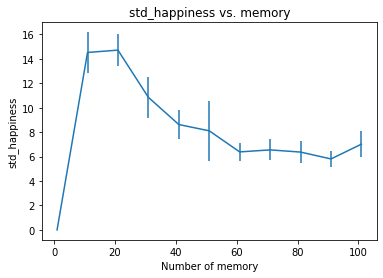

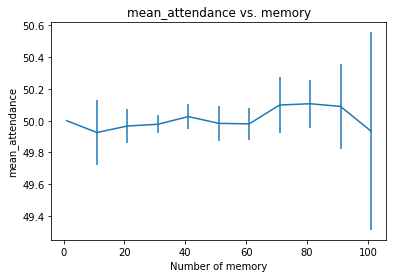

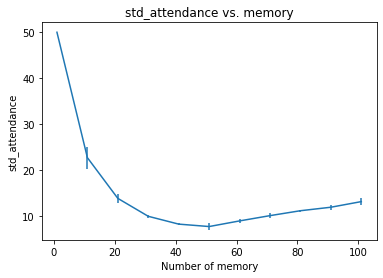

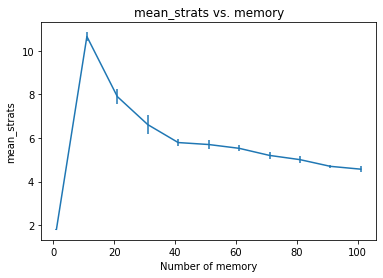

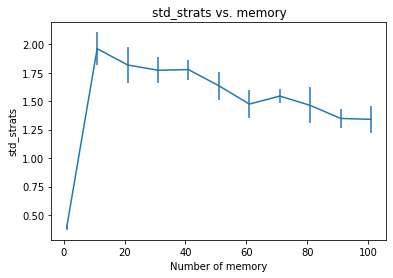

In [19]:
n_reps = 5
x_name = "memory"
x_range = range(1,102, 10)
rng = np.random.default_rng(81)

kwargs = {
    "strategies": 20,
    "threshold": 50
}

experiment(x_name, x_range, n_reps, rng, kwargs=kwargs)

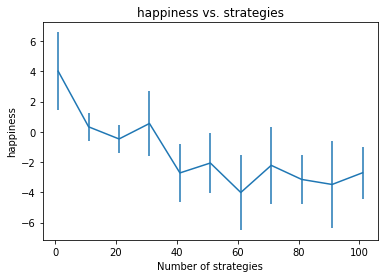

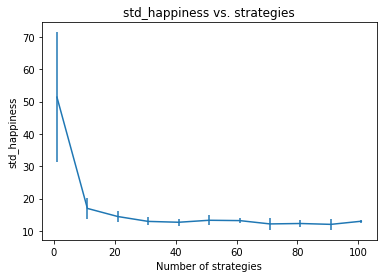

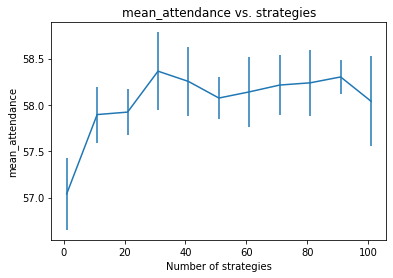

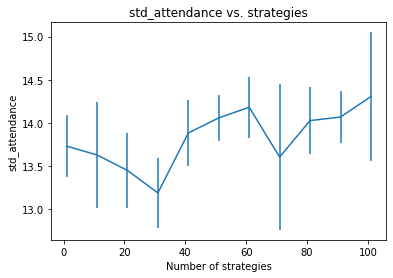

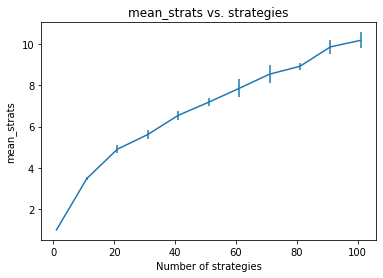

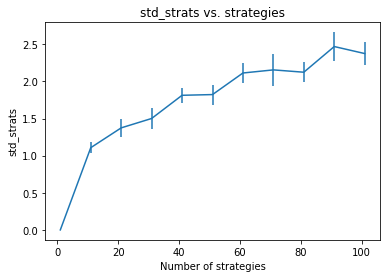

In [21]:
n_reps = 5
x_name = "strategies"
x_range = range(1,102, 10)
rng = np.random.default_rng(81)

experiment(x_name, x_range, n_reps, rng)